In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from math import exp, log10
sns.set()
# Scipy Optimization Algorithm is used to find the optimal parameters
import scipy.optimize as opt
# Scipy is needed to load a MATLAB digit dataset
from scipy.io import loadmat
#Sklearn OneHot Encoder to Encode categorical integer features
from sklearn.preprocessing import OneHotEncoder
import matplotlib.cm as cm #Used to display images in a specific colormap
import random
from IPython.display import Image, display

# In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.


There are 5000 training examples in ex3data1.mat, where each training example is a
20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by
a 
oating point number indicating the grayscale intensity at that location.
The 20 by 20 grid of pixels is \unrolled" into a 400-dimensional vector. Each
of these training examples becomes a single row in our data matrix X. This
gives us a 5000 by 400 matrix X where every row is a training example for a
handwritten digit image.

The second part of the training set is a 5000-dimensional vector (y) that
contains labels for the training set.

In [61]:
data = loadmat('ex4data1')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [62]:
dataX = pd.DataFrame.from_dict(data['X'])
dataX.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
datay = pd.DataFrame.from_dict(data['y'])
datay.head()

,0
0,10
1,10
2,10
3,10
4,10


In [64]:
pd.unique(datay[0]) # the '0' is shown as '10' 

array([10,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [65]:
# replace the 10 on 0
datay[0][datay[0]==10] = 0

In [66]:
pd.unique(datay[0])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

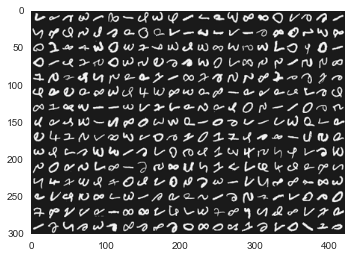

In [67]:
#Show the numbers (example)
num_col = 21  #number of shown digits in the column
num_row = 15  ##number of shown digits in the row
def draw_sample(num_col, num_row):
    Ximg = np.array(dataX)
    a=random.randint(0,4999)
    d=Ximg[a,:].reshape(20,20)
    b=Ximg[0,:].reshape(20,20)

    a=random.randint(0,4999)
    b=np.empty(shape=(num_row*20,20))
    for i in range (num_col):
        a=random.randint(0,4999)
        d=Ximg[a,:].reshape(20,20)
        for i in range (num_row-1):
            Ximg = np.array(dataX)
            a=random.randint(0,4999)
            d=np.vstack((d, Ximg[a,:].reshape(20,20)))
        b=np.column_stack((b, d))
    imgplot = plt.imshow(b[:,20:], cmap=cm.Greys_r)
    ax = plt.gca()
    ax.grid(False)  #Delete the grid
draw_sample(num_col, num_row)

In [68]:
# Construct the X any Y matrix arrays, the values in dataX are normalized already (div by 255)
X = np.array(dataX)
#Add ones to the X matrix
X=np.column_stack((np.ones(len(X)),X))

Y = np.array(datay)
print('X (feature) matrix shape is ', X.shape)
print('Y matrix shape is ', Y.shape)

X (feature) matrix shape is  (5000, 401)
Y matrix shape is  (5000, 1)


In [69]:
#Encode the Y matrix
enc = OneHotEncoder(sparse=False) 
Y_enc=enc.fit_transform(Y)
Y_enc.shape

(5000, 10)

In [70]:
#Load the initial parameters from the MATLAB data
weights = loadmat('ex4weights')

In [71]:
weight1 = pd.DataFrame.from_dict(weights['Theta1'])
weight1.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,-0.022562,-1.056242e-08,2.194147e-09,-0.000007,0.000089,-0.000243,-0.002710,0.001458,0.002460,0.000714,...,0.000531,0.004699,0.002216,-0.009471,-0.000985,0.002048,0.000628,-0.000013,-5.041751e-06,2.804644e-09
1,-0.098381,7.661687e-09,-9.758737e-09,0.000001,-0.000006,-0.000031,-0.000512,-0.001015,-0.001008,0.000139,...,0.003958,-0.003567,-0.012818,0.001168,0.000606,0.002229,0.000399,-0.000056,2.009410e-07,3.544229e-09
2,0.116156,-8.776545e-09,8.160378e-09,-0.000001,0.000022,-0.000076,-0.000776,-0.000987,0.000314,0.000417,...,-0.000357,-0.004825,0.002448,-0.003781,0.001872,0.004688,0.001204,-0.000121,-2.336697e-06,-7.506681e-09
3,-0.239693,-6.318358e-09,2.641286e-09,-0.000001,-0.000071,0.001023,0.009066,-0.001463,0.002825,0.002203,...,-0.001315,0.005455,0.003939,-0.002683,-0.000305,0.001602,0.000313,-0.000051,8.684092e-07,9.887436e-09
4,-0.731625,8.147767e-09,5.858792e-09,-0.000003,0.000026,0.000159,0.000516,-0.003092,0.000418,0.000781,...,0.003799,0.007410,0.006901,-0.005854,0.000138,0.002553,0.000699,-0.000053,-2.653819e-06,-2.176609e-09


In [72]:
theta1 = np.array(weight1)
theta1.shape

(25, 401)

In [73]:
weight2 = pd.DataFrame.from_dict(weights['Theta2'])
weight2.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-0.761004,-1.212445,-0.101871,-2.368501,-1.057781,-2.208236,0.563838,1.211053,2.210310,0.444562,...,-0.233656,-1.520145,1.153242,0.103681,-0.372077,-0.615300,-0.125684,-2.271930,-0.718362,-1.296903
1,-0.617852,0.615592,-1.265506,1.857454,-0.918533,-0.055026,-0.385898,1.295209,-1.568433,-0.970264,...,-2.441744,-0.856303,-0.298256,-2.079479,-1.293324,0.899820,0.283066,2.311805,-2.464441,1.456565
2,-0.689341,-1.945382,2.013606,-3.123162,-0.236176,1.386809,0.909824,-1.547744,-0.798309,-0.655998,...,-1.638986,1.202730,-1.202459,-1.834460,-1.880130,-0.340561,0.236925,-1.061379,1.027592,-0.476908
3,-0.678325,0.462992,0.584923,-0.165018,1.932642,-0.229658,-1.847315,0.490118,1.071461,-3.319056,...,-0.684279,-1.647136,0.211531,-0.274224,1.725998,1.324187,-2.639845,-0.080559,-2.035108,-1.461238
4,-0.596643,-2.044818,2.056984,1.951009,0.176377,-2.161412,-0.403947,1.801575,-1.562787,-0.252530,...,-0.674888,1.140665,1.324312,3.211585,-2.158889,-2.601641,-3.222647,-1.896129,-0.874881,2.510386


In [74]:
theta2 = np.array(weight2)
theta2.shape

(10, 26)

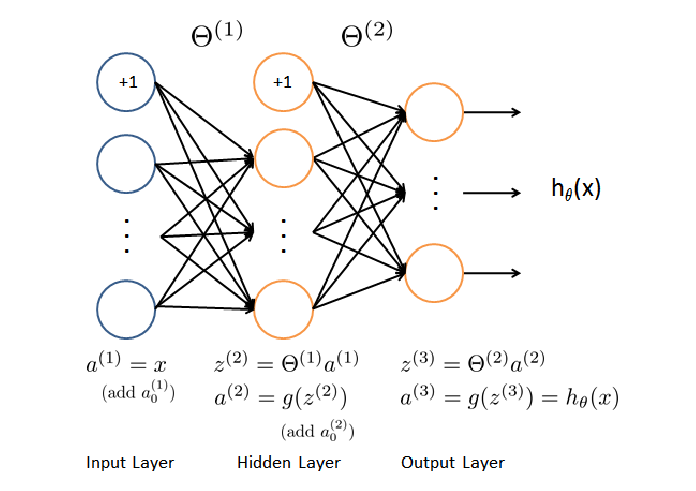

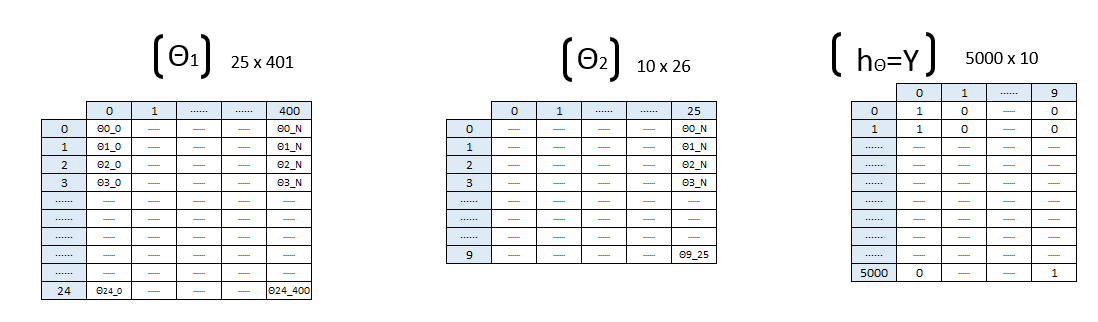

In [75]:
display(Image(filename='nw_1.PNG', embed=True, width=500))
display(Image(filename='nw_4.PNG', embed=True, width=900))

In [76]:
def sigmoid(x):
    g = 1/(1+np.exp(-x))
    return g

### Funtion for Forward propagation

In [77]:
#Funtion for Forward propagation
def forward_prop(x, t1, t2):
    t1=t1.T
    t2=t2.T
    a1 = x #5000 X 401
    z2 = np.matmul(a1,t1)
    a2 = sigmoid(z2)
    a2 = np.column_stack((np.ones(len(a2)),a2)) #5000 X 26
    z3 = np.matmul(a2,t2)
    a3 = sigmoid(z3)
    return z2, a2, z3, a3

In [78]:
#Check the Function above
z2, a2, z3, a3 = forward_prop(X, theta1, theta2)
a3.shape  #Should be 5000 X 10, same as Y

(5000, 10)

### Initial Weights defining

In [79]:
#This range of values ensures that the parameters are kept small and makes the learning more efficient.
# Here calculation is shown as example
epsilon_init = round((6/(len(theta1[1,:]) + len(theta2[1,:])))**0.5,2)
print ('epsilon_init = ',epsilon_init)

epsilon_init =  0.12


In [80]:
input_size=400
hidden_size=25
num_labels=10
lamb = 0

# epsilon_init consider the input and hidden sizes
epsilon_init = round((6/(input_size + hidden_size))**0.5,2)

param = (np.random.rand((input_size+1)*hidden_size + (hidden_size+1)*num_labels) - 0.5)*epsilon_init/0.5

# check the code for initial values outside of Backpropagation Function
t1 = param[:(input_size+1)*hidden_size].reshape(hidden_size,input_size+1)
t2 = param[(input_size+1)*hidden_size:].reshape(num_labels,hidden_size+1)
print ('t1 shape', t1.shape,'t1 min =', t1.min(),'t1 max =', t1.max())
print ('t2 shape', t2.shape, 't2 min =', t2.min(),'t2 max =', t2.max())

t1 shape (25, 401) t1 min = -0.119970630947 t1 max = 0.119978720392
t2 shape (10, 26) t2 min = -0.119183654397 t2 max = 0.119905350251


### Cost Function

In [81]:
#Cost function
def J(param, x, y, input_size, hidden_size, num_labels, lamb):
    m = len(y)
    t1 = param[:(input_size+1)*hidden_size].reshape(hidden_size,input_size+1)
    t2 = param[(input_size+1)*hidden_size:].reshape(num_labels,hidden_size+1)
    z2, a2, z3, a3 = forward_prop(x, t1, t2)
    c = (np.multiply(-y,np.log(a3)) - np.multiply((1-y),np.log(1-a3)))
    c = c.sum()/m
    
    # Regularization part    //np.sum(np.square(theta1[:,1:])  //np.power(theta2,2)[:,1:].sum()
    reg = (np.sum(np.square(theta1[:,1:])) + np.power(theta2,2)[:,1:].sum())*lamb/(2*m)
    J = c+reg
    return J

In [82]:
cost = J(param, X, Y_enc, input_size, hidden_size, num_labels, lamb)
print('The Cost of the function is',cost)

The Cost of the function is 6.67068010801


In [83]:
check_param = np.r_[theta1.ravel(), theta2.ravel()]

In [84]:
cost = J(check_param, X, Y_enc, input_size, hidden_size, num_labels, lamb)
print('The Cost of the function is',cost)

The Cost of the function is 10.4414596728


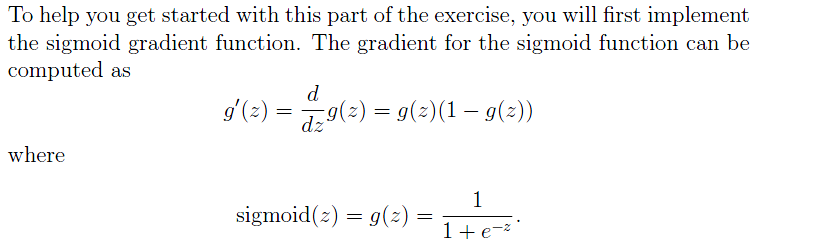

In [85]:
display(Image(filename='nw_2.PNG', embed=True, width=500))

In [86]:
# sigm=True  mean that the argument (x) is simoid funciton already
def sigm_grad(x, sigm=True):
    if sigm is False:
        x=sigmoid(x)
    sg = x*(1-x)
    return sg

#Check the function
sigm_grad(0, sigm=False)

0.25

### Backpropagation Funciton

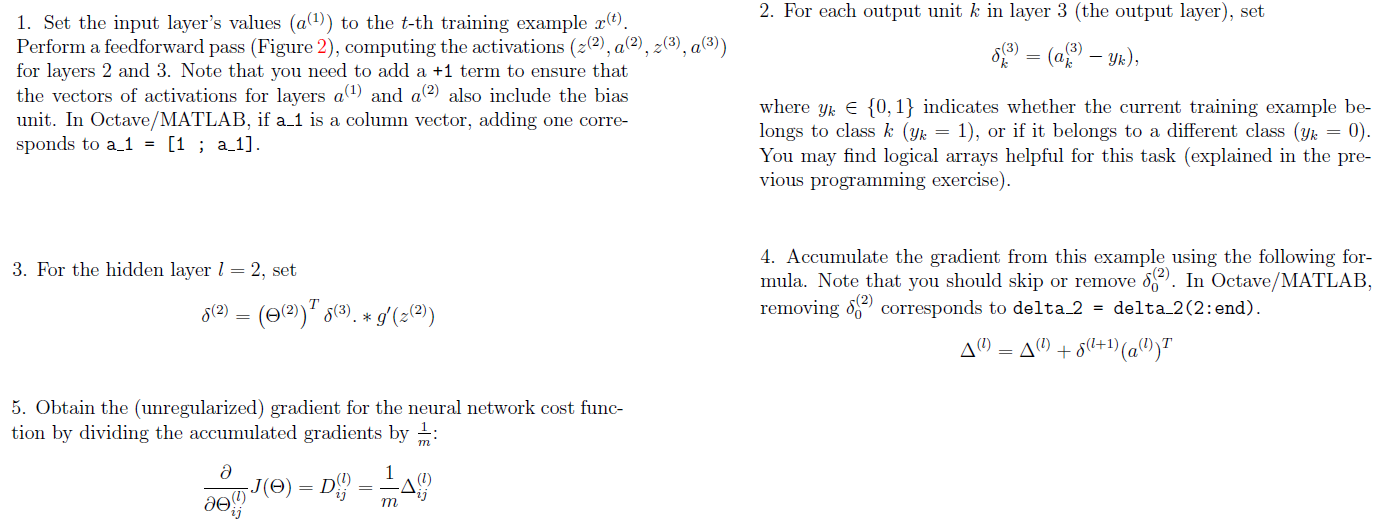

In [87]:
display(Image(filename='nw_3.PNG', embed=True, width=1000))

## As example d2 matrix calculaiton is shown below

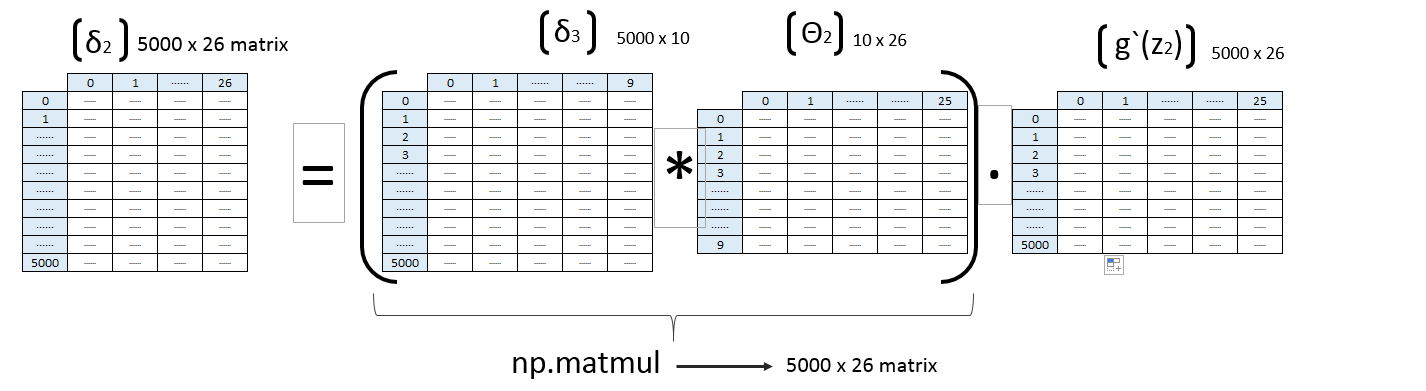

In [88]:
display(Image(filename='nw_5.PNG', embed=True, width=1000))

In [89]:
def backprop(param, x, y, input_size, hidden_size, num_labels, lamb):
    m = len(y)

    '''
    #Cost part same as J
    t1 = param[:(input_size+1)*hidden_size].reshape(hidden_size,input_size+1)
    t2 = param[(input_size+1)*hidden_size:].reshape(num_labels,hidden_size+1)
    z2, a2, z3, a3 = forward_prop(x, t1, t2)
    c = (np.multiply(-y,np.log(a3)) - np.multiply((1-y),np.log(1-a3)))
    c = c.sum()/m
    # Cost Regularization
    reg = (np.power(theta1,2)[:,1:].sum() + np.power(theta2,2)[:,1:].sum())*lamb/(2*m)
    
    J = c + reg
    '''

    # Gradient part
    t1 = param[:(input_size+1)*hidden_size].reshape(hidden_size,input_size+1)
    t2 = param[(input_size+1)*hidden_size:].reshape(num_labels,hidden_size+1)
    
    z2, a2, z3, a3 = forward_prop(x, t1, t2)  #a2 5000 X 26
    
    d3 = a3 - y  # 5000 x 10
    d2 = np.matmul(d3,t2) #5000 X 26
    d2 = np.multiply(d2,sigm_grad(a2, sigm=True))  #5000 X 26
    
    D1 = np.matmul(d2[:,1:].T,x)/m  # 25 X 401    Skip the first column in d2 since Theta1 doesnt change bias parameter
    D2 = np.matmul(d3.T,a2)/m  # 10 X 26
    
    #Gradient Regularization, first bias column with (1) is not regularized
    D1[:,1:] = D1[:,1:] + (t1[:,1:] * lamb) / m   # 25 X 401
    D2[:,1:] = D2[:,1:] + (t2[:,1:] * lamb) / m   # 10 X 26
    
    grad = np.concatenate((np.ravel(D1), np.ravel(D2)))
    
    return grad
#If Cost part is active: return J, grad

In [90]:
backprop(param, X, Y_enc, input_size, hidden_size, num_labels, lamb)

array([ 0.01251913,  0.        ,  0.        , ...,  0.19959431,
        0.16610068,  0.14108734])

In [91]:
# jac=True and fun=backprop if backprop  function return J, grad

fmin = opt.minimize(fun=J,  x0=param, args=(X, Y_enc, input_size, hidden_size, num_labels, lamb),  
                method='TNC', jac=backprop, options={'maxiter': 250})

In [92]:
fmin.x.shape

(10285,)

In [93]:
# Form theta1 and theta2 from one array weights
theta1 = fmin.x[:(input_size+1)*hidden_size].reshape(hidden_size,input_size+1)
theta2 = fmin.x[(input_size+1)*hidden_size:].reshape(num_labels,hidden_size+1)

# Accuracy

In [94]:
def accuracy(theta, Y):
    m=len(Y)
    theta1 = theta[:(input_size+1)*hidden_size].reshape(hidden_size,input_size+1)
    theta2 = theta[(input_size+1)*hidden_size:].reshape(num_labels,hidden_size+1)
    z2, a2, z3, a3 = forward_prop(X, theta1, theta2)
    y_pred = np.array(np.argmax(a3, axis=1)) 
    accur = np.array([1 for (a,b) in zip(y_pred,Y) if a==b ]).sum()/m
    return accur, y_pred

In [95]:
accur, y_pred = accuracy(fmin.x, Y)
print ('Accuracy of the algorithm is ', accur)

Accuracy of the algorithm is  0.9996


In [96]:
z2, a2, z3, a3 = forward_prop(X, theta1, theta2)

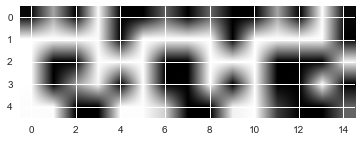

In [97]:
#Show the numbers in the second layer (example)
Ximg = np.array(a2[:,1:])
d=Ximg[0,:].reshape(5,5)
for i in range (1,3):
    d=np.column_stack((d, Ximg[i,:].reshape(5,5)))
imgplot = plt.imshow(d, cmap='gray')

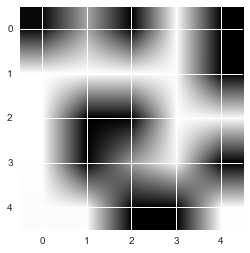

In [98]:
imgplot = plt.imshow(Ximg[0,:].reshape(5,5), cmap='gray')

### Try to use scipy.optimize.fmin_cg. In the (backprop) should be returned only gradient (just delete (J) in the return)

In [99]:
#Try to use scipy.optimize.fmin_cg
res = opt.fmin_cg(J, x0=param, fprime = backprop, args=(X, Y_enc, input_size, hidden_size, num_labels, lamb),  
                maxiter = 250)

         Current function value: 0.004563
         Iterations: 250
         Function evaluations: 1157
         Gradient evaluations: 1157


In [100]:
res.shape

(10285,)

In [101]:
accur, y_pred = accuracy(res, Y)
print ('Accuracy of the algorithm is ', accur)

Accuracy of the algorithm is  1.0


## Heatmap of predicted and actual values

In [102]:
from sklearn.metrics import confusion_matrix

In [103]:
mat = confusion_matrix(Y, y_pred)

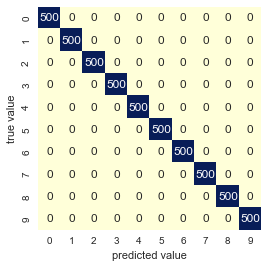

In [104]:
sns.set()
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap="YlGnBu", fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

# Additional Materials

In [105]:
#Cost function with backpropagation
#http://nbviewer.jupyter.org/github/JWarmenhoven/Machine-Learning/blob/master/notebooks/Programming%20Exercise%204%20-%20Neural%20Networks%20Learning.ipynb


def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, features, classes, reg):
    
    # When comparing to Octave code note that Python uses zero-indexed arrays.
    # But because Numpy indexing does not include the right side, the code is the same anyway.
    theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size,(input_layer_size+1))
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels,(hidden_layer_size+1))

    m = features.shape[0]
    #y_matrix = pd.get_dummies(classes.ravel()).as_matrix() 
    y_matrix = classes
    
    # Cost
    a1 = features # 5000x401
        
    z2 = theta1.dot(a1.T) # 25x401 * 401x5000 = 25x5000 
    a2 = np.c_[np.ones((features.shape[0],1)),sigmoid(z2.T)] # 5000x26 
    
    z3 = theta2.dot(a2.T) # 10x26 * 26x5000 = 10x5000 
    a3 = sigmoid(z3) # 10x5000
    
    J = -1*(1/m)*np.sum((np.log(a3.T)*(y_matrix)+np.log(1-a3).T*(1-y_matrix))) + \
        (reg/(2*m))*(np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))

    # Gradients
    d3 = a3.T - y_matrix # 5000x10
    d2 = theta2[:,1:].T.dot(d3.T)*sigm_grad(z2) # 25x10 *10x5000 * 25x5000 = 25x5000
    
    delta1 = d2.dot(a1) # 25x5000 * 5000x401 = 25x401
    delta2 = d3.T.dot(a2) # 10x5000 *5000x26 = 10x26
    
    theta1_ = np.c_[np.ones((theta1.shape[0],1)),theta1[:,1:]]
    theta2_ = np.c_[np.ones((theta2.shape[0],1)),theta2[:,1:]]
    
    theta1_grad = delta1/m + (theta1_*reg)/m
    theta2_grad = delta2/m + (theta2_*reg)/m
    
    return(J, theta1_grad, theta2_grad)

In [106]:
#Gives the same result as my
nnCostFunction(check_param, input_size, hidden_size, num_labels, X, Y_enc, lamb)[0]

10.441459672777979